# Fine-Tuning on Pre-Training Data: A Model Comparison

In this notebook, we fine-tune a large language model (LLM) on the Bible (using both standard and parameter-efficient fine-tuning) and evaluate any potential performance increase on the BibleQA dataset.

To start, we install and import our necessary dependencies.

In [1]:
!pip install transformers datasets peft pandas tqdm seaborn torch

In [2]:
import csv
import torch
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from datasets import load_dataset
from peft import get_peft_model, LoraConfig
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments, TrainerCallback,
    DataCollatorForLanguageModeling
)
N_FINE_TUNING_EPOCHS = 4
FINE_TUNING_BATCH_SIZE = 8

Next, we load in the biblical text as a Hugging Face dataset for later fine-tuning.

In [3]:
bible_text_dataset = load_dataset('text', data_files={'train': 'bible.txt'})
bible_text_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 31104
    })
})

Before proceeding, we print a sample from the Bible dataset as a sanity check.

In [4]:
bible_text_dataset['train'][3000]['text']

'Leviticus 11:1\tAnd Jehovah spake unto Moses and to Aaron, saying unto them,'

We now prepare our BibleQA dataset as question-answer pairs and display a sample.

In [5]:
bible_qa_pairs = {
    'questions': [],
    'answers': []
}
with open('bible_qa_pairs.csv') as bible_qa_pairs_csv_file:
    bible_qa_csv_file_reader = csv.reader(bible_qa_pairs_csv_file, delimiter='\t')
    header = next(bible_qa_csv_file_reader)
    for row in bible_qa_csv_file_reader:
        if row:
            bible_qa_pairs['questions'].append(
                ''.join(row[0].split('. ')[1:]))
            bible_qa_pairs['answers'].append(
                ''.join(''.join(row[1].split('. ')[1:]).split(' (')[:1]))
bible_qa_pairs_df = pd.DataFrame(bible_qa_pairs)
bible_qa_pairs_df.head()

,questions,answers
0,What was the name of Jesus' mother?,Mary
1,What was the name of the garden where Adam and...,Eden
2,With what food did Jesus feed the multitude?,Five loaves and two fishes
3,What method did the Romans use to kill Jesus?,Crucifixion
4,From which part of Adam's body did God create ...,Rib


We should now load in both our models and our tokenizer. In the case of the former, we load in three instances of the model, one for each of our evaluations.

In [6]:
model_name = 'openai-community/gpt2-large'
pretrained_model = AutoModelForCausalLM.from_pretrained(model_name)
fine_tuned_model = AutoModelForCausalLM.from_pretrained(model_name)
peft_model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Now that we have our tokenizer, we can tokenize our biblical text for fine-tuning.

In [7]:
def tokenize_bible_text(examples):
    return tokenizer(
        examples['text'], truncation=True,
        padding='max_length', max_length=512
    )
tokenized_bible_text = bible_text_dataset.map(
    tokenize_bible_text, batched=True
)

Before we dig into fine-tuning, we create a callback that will collect the loss over time from fine-tuning.

In [8]:
class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.losses.append(logs['loss'])

fine_tuned_loss_callback = LossCallback()
peft_loss_callback = LossCallback()

Fine-tuning can now take place. We first fine-tune in a straightforward fashion, simply performing more training but with our specific data. Note that the epoch count was set to 4 and the batch size to 8 as global variables above. (For fair comparison, these same hyperparameters will also be set for PEFT.)

In [9]:
fined_tuned_data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)
fine_tuned_training_args = TrainingArguments(
    output_dir='./fine_tuning_results',
    overwrite_output_dir=True,
    num_train_epochs=N_FINE_TUNING_EPOCHS,
    per_device_train_batch_size=FINE_TUNING_BATCH_SIZE,
    save_strategy='no'
)
fine_tuned_trainer = Trainer(
    model=fine_tuned_model,
    args=fine_tuned_training_args,
    train_dataset=tokenized_bible_text['train'],
    data_collator=fined_tuned_data_collator,
    callbacks=[fine_tuned_loss_callback]
)
fine_tuned_trainer.train()

Step,Training Loss
500,2.664100
1000,2.504100
1500,2.457900
2000,2.410900
2500,2.358000
3000,2.326700
3500,2.311500
4000,2.147500
4500,1.796300
5000,1.796400


TrainOutput(global_step=15552, training_loss=1.6144247307698913, metrics={'train_runtime': 20714.9661, 'train_samples_per_second': 6.006, 'train_steps_per_second': 0.751, 'total_flos': 2.707510272196608e+17, 'train_loss': 1.6144247307698913, 'epoch': 4.0})

We also visualize the loss curve produced from fine-tuning.

<Axes: title={'center': 'Fine-Tuning Model Loss'}, xlabel='Training Steps', ylabel='Loss'>

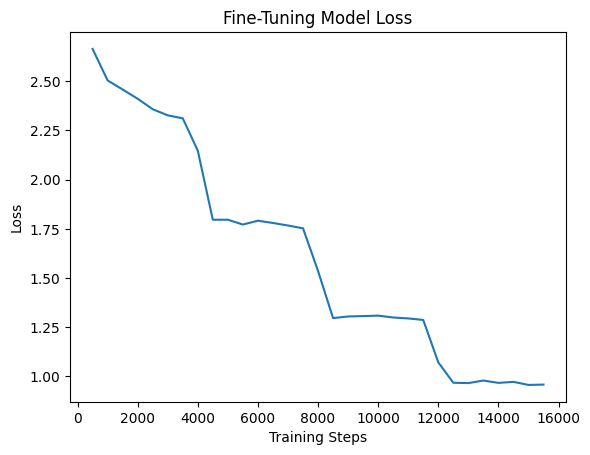

In [10]:
fine_tuned_losses = fine_tuned_loss_callback.losses
fine_tuned_loss_lineplot = sns.lineplot(
    x=[(step + 1) * 500 for step in range(len(fine_tuned_losses))],
    y=fine_tuned_losses
)
fine_tuned_loss_lineplot.set(
    title='Fine-Tuning Model Loss',
    xlabel='Training Steps', ylabel='Loss'
)
fine_tuned_loss_lineplot

Before performing parameter-efficient fine-tuning (PEFT), we need to determine which parts of the model to apply it to. Our `gpt2-large` model features the following structure.

In [11]:
peft_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

The bulk of the model is a series of 36 `GPT2Block` modules. The parameter-containing modules within a given `GPT2Block` are `c_attn` (convolutional attention), `c_fc` (fully connected convolutional), `c_proj` (convolutional projection). Note that the latter is a part of both the attention portion and the multi-layer perceptron (MLP) portion. Before selecting which layers we'd like to apply PEFT to, let's see what the parameter counts of these layers are.

In [12]:
for name, module in peft_model.named_modules():
    if 'c_' in name and 'transformer.h.0' in name: # We only need to see counts
                                                   # for one GPT2Block
        layer_params = sum(p.numel() for p in module.parameters())
        print(f"Layer: {name}, Parameters: {layer_params}")

Layer: transformer.h.0.attn.c_attn, Parameters: 4919040
Layer: transformer.h.0.attn.c_proj, Parameters: 1639680
Layer: transformer.h.0.mlp.c_fc, Parameters: 6558720
Layer: transformer.h.0.mlp.c_proj, Parameters: 6554880


All of these modules contain a very high number of parameters. We will thus apply PEFT to all of them, namely in the form of low-rank adaptation (LoRA).

In [13]:
lora_config = LoraConfig(
    target_modules=['c_attn', 'c_proj', 'c_fc']
)
peft_model = get_peft_model(peft_model, lora_config)

peft_data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)
peft_training_args = TrainingArguments(
    output_dir='./peft_results',
    overwrite_output_dir=True,
    num_train_epochs=N_FINE_TUNING_EPOCHS,
    per_device_train_batch_size=FINE_TUNING_BATCH_SIZE,
    save_strategy='no'
)
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_bible_text['train'],
    data_collator=peft_data_collator,
    callbacks=[peft_loss_callback]
)
peft_trainer.train()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss
500,2.908600
1000,2.539200
1500,2.505000
2000,2.479400
2500,2.458200
3000,2.444300
3500,2.457500
4000,2.416600
4500,2.420400
5000,2.408100


Step,Training Loss
500,2.908600
1000,2.539200
1500,2.505000
2000,2.479400
2500,2.458200
3000,2.444300
3500,2.457500
4000,2.416600
4500,2.420400
5000,2.408100


TrainOutput(global_step=15552, training_loss=2.4016281577294745, metrics={'train_runtime': 16026.8781, 'train_samples_per_second': 7.763, 'train_steps_per_second': 0.97, 'total_flos': 2.7300536965398528e+17, 'train_loss': 2.4016281577294745, 'epoch': 4.0})

As above, we visualize the loss curve.

<Axes: title={'center': 'PEFT Model Loss'}, xlabel='Training Steps', ylabel='Loss'>

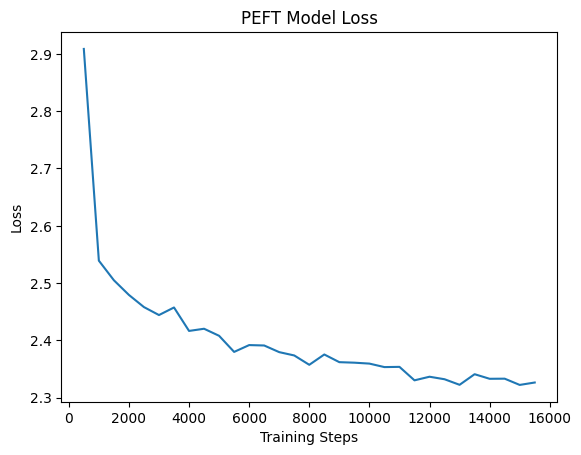

In [14]:
peft_losses = peft_loss_callback.losses
peft_loss_lineplot = sns.lineplot(
    x=[(step + 1) * 500 for step in range(len(peft_losses))],
    y=peft_losses
)
peft_loss_lineplot.set(
    title='PEFT Model Loss',
    xlabel='Training Steps', ylabel='Loss'
)
peft_loss_lineplot

Finally, we can evaluate our models on the question-answer pairs. Note that we embed our questions into a few-shot learning prompt to encourage the text-continuation model to output answers to the question (we also explicitly inform the model of the biblical nature of the questions).

In [18]:
def generate_answer(model: AutoModelForCausalLM, question: str) -> str:
    if not question.strip():
        return ''

    prompt =\
    f'The following are questions and answers about the Bible.\n\n\
Q: Who was the first man?\n\
A: Adam\n\n\
Q: What was special about Samson?\n\
A: He was very strong\n\n\
Q: Where was Jesus born?\n\
A: Bethlehem\n\n\
Q: {question}\n\
A: '
    input_tokens = tokenizer.encode(
        question,
        return_tensors='pt'
    ).to(model.device)
    attention_mask = input_tokens.ne(
        tokenizer.pad_token_id
    ).to(model.device)
    model_output = model.generate(
        input_tokens,
        max_new_tokens=15,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id,
        attention_mask=attention_mask
    )
    answer = tokenizer.decode(
        model_output[0],
        skip_special_tokens=True
    )
    answer = answer.replace(
        prompt, '').replace(
        question, '').replace(
        '\n', ' '
    )
    return answer

pretrained_model_answers = []
fine_tuned_model_answers = []
peft_model_answers = []
for question in tqdm(bible_qa_pairs_df['questions']):
    pretrained_model_answers.append(
        generate_answer(pretrained_model, question))
    fine_tuned_model_answers.append(
        generate_answer(fine_tuned_model, question))
    peft_model_answers.append(
        generate_answer(peft_model, question))

bible_qa_pairs_df['pretrained_model_answers'] = pretrained_model_answers
bible_qa_pairs_df['fine_tuned_model_answers'] = fine_tuned_model_answers
bible_qa_pairs_df['peft_model_answers'] = peft_model_answers
bible_qa_pairs_df.head()

100%|██████████| 886/886 [36:18<00:00,  2.46s/it]


,questions,answers,pretrained_model_answers,fine_tuned_model_answers,peft_model_answers
0,What was the name of Jesus' mother?,Mary,The name of Jesus' mother was Mary. Was Jesus,"Elisabeth, according to the word of the angel...","(Matthew 1:15\tAnd he said unto them, Blessed"
1,What was the name of the garden where Adam and...,Eden,The Garden of Eden. What was the name of the,And the name of the first garden was Mahanaim...,It was the garden of Eden. And out of it came...
2,With what food did Jesus feed the multitude?,Five loaves and two fishes,The answer is simple: He fed them with the v...,"with oxen, or with sheep, or with goats? with...",And what did he do with the multitude? He gav...
3,What method did the Romans use to kill Jesus?,Crucifixion,The Romans killed Jesus by crucifixion. The...,They hanged him on a tree. What manner of bod...,And why did they not crucify him? And why did...
4,From which part of Adam's body did God create ...,Rib,The Bible says that God created Eve from Ada...,And from which part of him was he taken when ...,And where is the beginning of the matter of t...


Finally, we can evaluate these responses against our ground-truth answers. For the sake of simplicity, an answer produced by the model was considered correct if the ground-truth answer was at least contained _somewhere_ within the response. When at least one model response is counted as correct for a given question, the question, the ground-truth answer, and each model's response is printed for observation.

In [19]:
pretrained_correct = 0
fine_tuned_correct = 0
peft_correct = 0
bible_qa_rows = bible_qa_pairs_df.to_dict(orient='records')
for row_index, row in enumerate(bible_qa_rows):
    one_correct = False
    if row['answers'] in row['pretrained_model_answers']:
        pretrained_correct += 1
        one_correct = True
    if row['answers'] in row['fine_tuned_model_answers']:
        fine_tuned_correct += 1
        one_correct = True
    if row['answers'] in row['peft_model_answers']:
        peft_correct += 1
        one_correct = True
    if one_correct:
        print( '------------------')
        print(f'QUESTION {row_index + 1}')
        print(f'Question: {row["questions"]}')
        print(f'Answer: {row["answers"]}')
        print(f'Pre-trained Model Answer: {row["pretrained_model_answers"]}')
        print(f'Fine-tuned Model Answer: {row["fine_tuned_model_answers"]}')
        print(f'PEFT Model Answer: {row["peft_model_answers"]}')
        print( '------------------\n\n')

------------------
QUESTION 1
Question: What was the name of Jesus' mother?
Answer: Mary
Pre-trained Model Answer:   The name of Jesus' mother was Mary.  Was Jesus
Fine-tuned Model Answer:  Elisabeth, according to the word of the angel, whose mouth was
PEFT Model Answer:   (Matthew 1:15	And he said unto them, Blessed
------------------


------------------
QUESTION 2
Question: What was the name of the garden where Adam and Eve lived?
Answer: Eden
Pre-trained Model Answer:   The Garden of Eden.  What was the name of the
Fine-tuned Model Answer:  And the name of the first garden was Mahanaim. And the name
PEFT Model Answer:  It was the garden of Eden. And out of it came forth the man
------------------


------------------
QUESTION 37
Question: What was the name of Moses' brother?
Answer: Aaron
Pre-trained Model Answer:   Moses was the brother of Aaron, the brother of Levi,
Fine-tuned Model Answer:  And they said, The son of Jesse. And they said, The name
PEFT Model Answer:  And the name

Finally, we calculate the accuracy of each model, also providing absolute number of questions correct.

In [20]:
pretrained_accuracy = pretrained_correct / len(bible_qa_rows)
fine_tuned_accuracy = fine_tuned_correct / len(bible_qa_rows)
peft_accuracy = peft_correct / len(bible_qa_rows)

print(f'Pre-trained Model Accuracy: {pretrained_accuracy} ' +\
      f'({pretrained_correct}/{len(bible_qa_rows)})')
print(f'Fine-tuned Model Accuracy: {fine_tuned_accuracy} ' +\
      f'({fine_tuned_correct}/{len(bible_qa_rows)})')
print(f'PEFT Model Accuracy: {peft_accuracy} ' +\
      f'({peft_correct}/{len(bible_qa_rows)})')

Pre-trained Model Accuracy: 0.023702031602708805 (21/886)
Fine-tuned Model Accuracy: 0.010158013544018058 (9/886)
PEFT Model Accuracy: 0.010158013544018058 (9/886)
